# Reinforcement Learning

**Grid World environment with DQN**

\- Vaibhav Rao
  50375332

\- Kunal Beniwal
  50381672



In [3]:
! pip install gym

#### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import time
import math
import sys

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)


#### Grid World Environment

In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 30
        self.state_map = state_map = {(0,0):0, (0,1):1,(0,2):2,(0,3):3,(1,0):4,(1,1):5,(1,2):6,(1,3):7,(2,0):8,(2,1):9,(2,2):10,(2,3):11,\
                          (3,0):12,(3,1):13,(3,2):14,(3,3):15}
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.trap = [0, 3]
        self.food = [1,1]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap)] = 0.3
        self.state[tuple(self.food)] = 0.1
        observation = self.agent_pos[0]*4 + self.agent_pos[1]
        return observation
    
    def step(self, action):
        self.prev_state = list(self.agent_pos)
        # Move DOWN
        if action == 0:
          self.agent_pos[0] += 1
        # Move UP
        if action == 1:
          self.agent_pos[0] -= 1
        # Move Right
        if action == 2:
          self.agent_pos[1] += 1
        # Move Left
        if action == 3:
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap)] = 0.3
        self.state[tuple(self.food)] = 0.1
        observation = self.state_map[(self.agent_pos[0],self.agent_pos[1])]
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 50
        if (self.agent_pos == self.trap).all():
          reward = -10
        if (self.agent_pos == self.food).all():
          reward = 15
        #if (self.agent_pos == self.prev_state).all():
        #  reward = -2
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all() else False
        info = {}

        return observation, reward, done, info

    # def step_stochastic(self, action):
    #     self.prev_state = list(self.agent_pos)
    #     self.same_pos_reward = True
    #     # Move DOWN (Stochastic with 0.1 probability of not moving)
    #     if action == 0:
    #       stoch_step = np.random.choice([1, 0], p=[0.9,0.1])
    #       self.agent_pos[0] += stoch_step
    #       if not stoch_step:
    #         self.same_pos_reward = False
    #     # Move UP
    #     if action == 1:
    #       self.agent_pos[0] -= 1
    #     # Move Right
    #     if action == 2:
    #       self.agent_pos[1] += 1
    #     # Move Left (Probability of not taking a left in this action = 0.3)
    #     if action == 3:
    #       stoch_step = np.random.choice([1, 0], p=[0.7,0.3])
    #       self.agent_pos[1] -= stoch_step
    #       if not stoch_step:
    #         self.same_pos_reward = False

    #     self.agent_pos = np.clip(self.agent_pos, 0, 3)
    #     self.state = np.zeros((4,4))
    #     self.state[tuple(self.agent_pos)] = 1
    #     self.state[tuple(self.goal_pos)] = 0.5
    #     self.state[tuple(self.trap)] = 0.3
    #     self.state[tuple(self.food)] = 0.1
    #     # observation = self.state.flatten()
    #     observation = self.agent_pos[0]*4 + self.agent_pos[1]
        
    #     reward = 0
    #     if (self.agent_pos == self.goal_pos).all():
    #       reward = 10
    #     if (self.agent_pos == self.trap).all():
    #       reward = -5
    #     if (self.agent_pos == self.food).all():
    #       reward = 2
    #     if (self.agent_pos == self.prev_state).all() and self.same_pos_reward:
    #       reward = -1
        
        
    #     self.timestep += 1
    #     done = True if self.timestep >= self.max_timesteps else False
    #     info = {}
        
    #     return observation, reward, done, info

    def render(self):
        plt.imshow(self.state)

    def run(self, agent):
      state = self.reset()
      self.R=0
      while True:            
        action = agent.act(state)
        nextState, reward, done, info = self.step(action)
        #if done and nextState!=15:
        #   reward -= 10
        #if not done and nextState > state:
        #  reward += 0.5
        edecay = agent.remember(state, action, reward, nextState, done)
        agent.replay(32)

        state = nextState
        self.R = self.R + reward

        if done:
            break
      return self.R,edecay


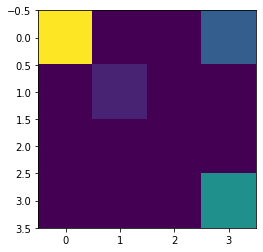

In [ ]:
env = GridEnvironment()
obs = env.reset()
env.render()

#### DQN AGENT ON Grid World PART I

In [ ]:
class Agent():
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space.n
    self.action_space = env.action_space.n
    self.lr = 0.0025
    self.model = self.buildModel()
    self.memory = deque(maxlen=3000)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.test_states = [x for x in range(self.observation_space)]
    self.test_states = tf.keras.utils.to_categorical(self.test_states)

  def buildModel(self):
    model = Sequential()
    model.add(Dense(64, input_shape=(self.observation_space,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
    return model

  def predictState(self, state):
    return self.model.predict(state)

  def act(self, state):
    if np.random.uniform(0,1) <= self.epsilon:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.predictState(self.test_states[state].reshape(-1, self.observation_space)))

  def sample(self,n):
    n = min(n, len(self.memory))
    return random.sample(self.memory, n)

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if ((self.epsilon > 0.01) and done):
        self.epsilon *= 0.9
    return self.epsilon
    

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    sample_batch = random.sample(self.memory, batch_size)
    states = np.array([ item[0] for item in sample_batch ])
    next_states = np.array([ item[3] for item in sample_batch ])
    predictedStates = self.model.predict(self.test_states[states].reshape(-1, self.observation_space))
    predictedNextStates = self.model.predict(self.test_states[next_states].reshape(-1, self.observation_space))
    x = np.zeros((batch_size, self.observation_space))
    y = np.zeros((batch_size, self.action_space))
   
    for i, (state, action, reward, next_state, done) in enumerate(sample_batch):
      target = predictedStates[i]
      target[action] = reward
      if not done:
        target[action] = reward + self.gamma * np.amax(predictedNextStates[i])
      x[i] = state
      y[i] = target
    # Printing the Q-table every 250 episodes.
    #q_table = self.predictState(np.asarray(self.test_states).reshape(-1, self.observation_space))
    # for terminal_state in [2, 8, 9, 10, 15]:  # The list represents terminal states.
    # # Manually setting terminal states to zero as the neural network will
    # # generalize and produce non-zero q-values for even the terminal states.
    # q_table[terminal_state] = 0 
    #print(f'\nQ-Table after episodes:\n', q_table)

    self.model.fit(x, y, batch_size=batch_size, epochs=1, verbose=0)


In [ ]:
env = GridEnvironment()

agent = Agent(env)
rewards = []
epsilon_decay = []
#episodes=250
episodes=50
for i in range(episodes):
    r,e = env.run(agent)
    rewards.append(r)
    epsilon_decay.append(e)
    print(f"Episode:{i+1} and Total reward for episode: {r}")


Episode:1 and Total reward for episode: 65
Episode:2 and Total reward for episode: 80
Episode:3 and Total reward for episode: -10
Episode:4 and Total reward for episode: 10
Episode:5 and Total reward for episode: 30
Episode:6 and Total reward for episode: 0
Episode:7 and Total reward for episode: 15
Episode:8 and Total reward for episode: 65
Episode:9 and Total reward for episode: 0
Episode:10 and Total reward for episode: 30
Episode:11 and Total reward for episode: 15
Episode:12 and Total reward for episode: 50
Episode:13 and Total reward for episode: 0
Episode:14 and Total reward for episode: 15
Episode:15 and Total reward for episode: 0
Episode:16 and Total reward for episode: 0
Episode:17 and Total reward for episode: 0
Episode:18 and Total reward for episode: 15
Episode:19 and Total reward for episode: 0
Episode:20 and Total reward for episode: 15
Episode:21 and Total reward for episode: 50
Episode:22 and Total reward for episode: 0
Episode:23 and Total reward for episode: 0
Episo

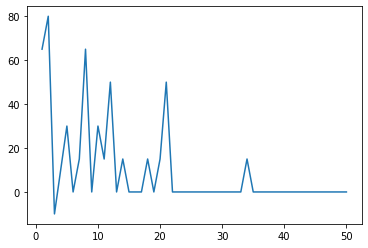

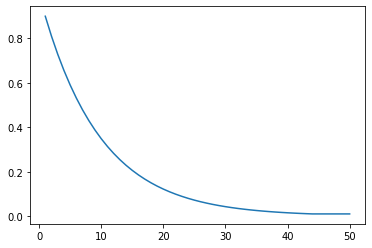

In [ ]:
plt.plot([i+1 for i in range(0, episodes)], rewards)
plt.show()
plt.plot([i+1 for i in range(0, episodes)], epsilon_decay)
plt.show()

Run For 5 Episode using GREEDY

episode: 0/5, reward: 0
episode: 1/5, reward: 0
episode: 2/5, reward: 0
episode: 3/5, reward: 0
episode: 4/5, reward: 0


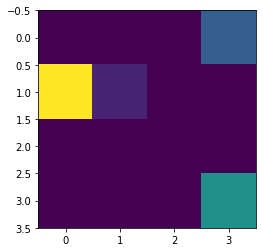

In [ ]:
test_states = [x for x in range(env.observation_space.n)]
test_states = tf.keras.utils.to_categorical(test_states)
for e in range(5):
  state = env.reset()
  done = False
  while not done:
    env.render()
    action = np.argmax(agent.predictState(test_states[state].reshape(-1, env.observation_space.n)))
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
      print("episode: {}/{}, reward: {}".format(e, 5, reward))
      break

#### Double DQN AGENT on Grid World (PART II)

In [ ]:
class AgentDDQN():
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space.n
    self.action_space = env.action_space.n
    self.lr = 0.0025
    self.model = self.buildModel()
    self.target_model = self.buildModel()
    self.memory = deque(maxlen=2000)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.test_states = [x for x in range(self.observation_space)]
    self.test_states = tf.keras.utils.to_categorical(self.test_states)

  def buildModel(self):
    model = Sequential()
    model.add(Dense(64, input_shape=(self.observation_space,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
    return model

  def predictState(self, state):
    return self.model.predict(state)

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  def act(self, state):
    if np.random.uniform(0,1) <= self.epsilon:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.predictState(self.test_states[state].reshape(-1, self.observation_space)))

  def sample(self,n):
    n = min(n, len(self.memory))
    return random.sample(self.memory, n)

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if ((self.epsilon > 0.01) and done):
        self.epsilon *= 0.9
    return self.epsilon

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    sample_batch = random.sample(self.memory, batch_size)
    states = np.array([ item[0] for item in sample_batch ])
    next_states = np.array([ item[3] for item in sample_batch ])

    target = self.model.predict(self.test_states[states].reshape(-1, self.observation_space))
    target_next = self.model.predict(self.test_states[next_states].reshape(-1, self.observation_space))
    target_val = self.target_model.predict(self.test_states[next_states].reshape(-1, self.observation_space))

    for i, (state, action, reward, next_state, done) in enumerate(sample_batch):
      target[i][action] = reward
      if not done:
        a = np.argmax(target_next[i])
        target[i][action] = reward + self.gamma * (target_val[i][a])
    self.model.fit(self.test_states[states].reshape(-1, self.observation_space), target, batch_size=batch_size, epochs=1, verbose=0)


In [ ]:
env = GridEnvironment()

states  = env.observation_space.n
actions = env.action_space.n
agent = AgentDDQN(env)
rewards = []
epsilon_decay = []
#episodes=150
episodes=50
for i in range(episodes):
    r,e = env.run(agent)
    ############# UPDATING AND SYNCING WEIGHTS EVERY 5 Epsiodes!
    if i % 5 == 0:
      agent.update_target_model()
    rewards.append(r)
    epsilon_decay.append(e)
    print(f"Episode:{i+1} and Total reward for episode: {r}")


Episode:1 and Total reward for episode: 10
Episode:2 and Total reward for episode: 45
Episode:3 and Total reward for episode: 70
Episode:4 and Total reward for episode: 35
Episode:5 and Total reward for episode: 75
Episode:6 and Total reward for episode: 75
Episode:7 and Total reward for episode: 5
Episode:8 and Total reward for episode: 120
Episode:9 and Total reward for episode: 180
Episode:10 and Total reward for episode: 150
Episode:11 and Total reward for episode: 165
Episode:12 and Total reward for episode: 210
Episode:13 and Total reward for episode: 195
Episode:14 and Total reward for episode: 105
Episode:15 and Total reward for episode: 165
Episode:16 and Total reward for episode: 195
Episode:17 and Total reward for episode: 195
Episode:18 and Total reward for episode: 195
Episode:19 and Total reward for episode: 210
Episode:20 and Total reward for episode: 210
Episode:21 and Total reward for episode: 225
Episode:22 and Total reward for episode: 225
Episode:23 and Total reward

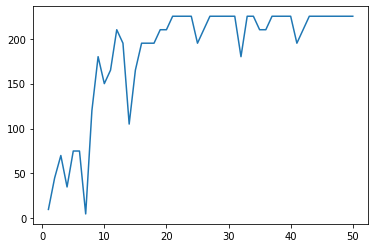

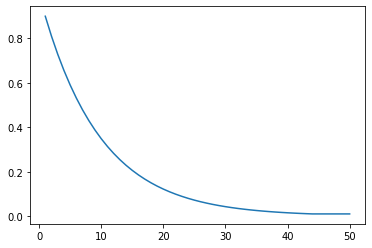

In [ ]:
plt.plot([i+1 for i in range(0, episodes)], rewards)
plt.show()
plt.plot([i+1 for i in range(0, episodes)], epsilon_decay)
plt.show()

episode: 0/5, Reward: 15
episode: 1/5, Reward: 15
episode: 2/5, Reward: 15
episode: 3/5, Reward: 15
episode: 4/5, Reward: 15


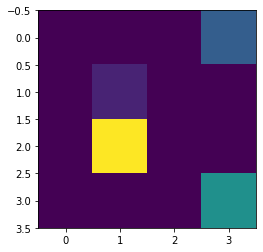

In [ ]:
test_states = [x for x in range(env.observation_space.n)]
test_states = tf.keras.utils.to_categorical(test_states)
for e in range(5):
  state = env.reset()
  done = False
  i = 0
  while not done:
    env.render()
    action = np.argmax(agent.predictState(test_states[state].reshape(-1, env.observation_space.n)))
    next_state, reward, done, _ = env.step(action)
    state = next_state
    i += 1
    if done:
      print("episode: {}/{}, Reward: {}".format(e, 5, reward))
      break

#### DQN Agent on Cartpole (PART II)

In [ ]:
class AgentCartpole():
  def __init__(self, env):
    self.env = env
    self.observation_space = env.env.observation_space.shape[0]
    self.action_space = env.env.action_space.n
    self.lr = 0.001
    self.model = self.buildModel()
    self.memory = deque(maxlen=3000)
    self.gamma = 0.95
    self.epsilon = 1.0

  def buildModel(self):
    model = Sequential()
    model.add(Dense(32, input_shape=(self.observation_space,), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
    return model

  def predictState(self, state):
    return self.model.predict(state.reshape(1, self.observation_space)).flatten()

  def act(self, state):
    if np.random.uniform(0,1) <= self.epsilon:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.predictState(state))

  def sample(self,n):
    n = min(n, len(self.memory))
    return random.sample(self.memory, n)

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if ((self.epsilon > 0.01) and done):
        self.epsilon *= 0.9
    return self.epsilon
    
  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    sample_batch = self.sample(batch_size)
    states = np.array([item[0] for item in sample_batch ])
    next_states = np.array([item[3] for item in sample_batch])

    predictedStates = self.model.predict(states)
    predictedNextStates = self.model.predict(next_states)

    #x = np.zeros((batch_size, self.observation_space))
    y = np.zeros((batch_size, self.action_space))

    for i, (state, action, reward, next_state, done) in enumerate(sample_batch):
      target = predictedStates[i]
      target[action] = reward
      if not done:
        target[action] = reward + self.gamma * np.amax(predictedNextStates[i])
      #x[i] = state
      y[i] = target

    self.model.fit(states, y, batch_size=batch_size, epochs=1, verbose=0)


class Environment:
  def __init__(self, env):
    self.env = gym.make(env)
  def run(self, agent):
    state = self.env.reset()
    self.score = 0
    while True:            
      action = agent.act(state)
      next_state, reward, done, info = self.env.step(action)
      reward = reward if not done or self.score == 499 else -100
      epsilon_decay=agent.remember(state, action, reward, next_state, done)
      agent.replay(256)    
      self.score += reward        
      state = next_state
      if done:
        self.score = self.score if self.score == 500 else self.score + 100
        break
    return self.score,epsilon_decay
    
  def test(self,agent):
    for e in range(5):
      state = self.env.reset()
      done = False
      i = 0
      while not done:
        #self.env.render()
        action = np.argmax(agent.predictState(state))
        next_state, reward, done, _ = self.env.step(action)
        state = next_state
        i += 1
        if done:
          print("episode: {}/{}, score: {}".format(e, 5, i))
          break

env = Environment('CartPole-v1') #Tried v1 with 64 neurons but in very slow training
#env = Environment('CartPole-v0')

agent = AgentCartpole(env)

reward=[]
epsilon_decay=[]
scores = []
episodes=2000
for i in range(episodes):
    s,e=env.run(agent)
    epsilon_decay.append(e)
    scores.append(s)
    if np.mean(scores[-min(10, len(scores)):]) > 490:
      print("Exiting training since score achieved")
      sys.exit()

    print(f"Episode:{i} and Total reward for episode: {s}")
    


Episode:0 and Total reward for episode: 19.0
Episode:1 and Total reward for episode: 19.0
Episode:2 and Total reward for episode: 13.0
Episode:3 and Total reward for episode: 28.0
Episode:4 and Total reward for episode: 13.0
Episode:5 and Total reward for episode: 25.0
Episode:6 and Total reward for episode: 12.0
Episode:7 and Total reward for episode: 14.0
Episode:8 and Total reward for episode: 8.0
Episode:9 and Total reward for episode: 9.0
Episode:10 and Total reward for episode: 11.0
Episode:11 and Total reward for episode: 8.0
Episode:12 and Total reward for episode: 10.0
Episode:13 and Total reward for episode: 10.0
Episode:14 and Total reward for episode: 11.0
Episode:15 and Total reward for episode: 11.0
Episode:16 and Total reward for episode: 11.0
Episode:17 and Total reward for episode: 9.0
Episode:18 and Total reward for episode: 9.0
Episode:19 and Total reward for episode: 59.0
Episode:20 and Total reward for episode: 33.0
Episode:21 and Total reward for episode: 28.0
Epi

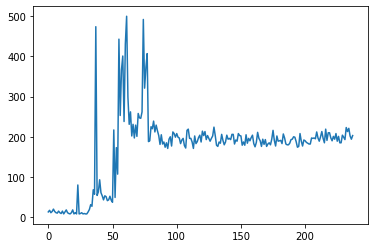

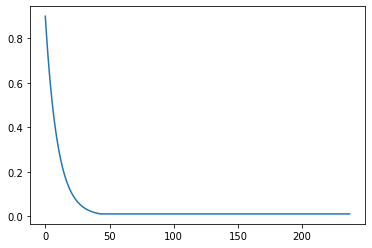

In [ ]:
plt.plot(scores)
plt.show()    
plt.plot(epsilon_decay)
plt.show()    

Take 5 steps with GREEDY LEARNT POLICY

In [1]:
env.test(agent)

NameError: ignored

#### DOUBLE DQN Agent ON Cartpole (Part II)

In [1]:
class AgentDDQNCartpole():
  def __init__(self, env):
    self.env = env
    self.observation_space = env.env.observation_space.shape[0]
    self.action_space = env.env.action_space.n
    self.lr = 0.001
    #Make 2 models for DDQN
    print("Double DQN Agent Initialized")
    self.model = self.buildModel()
    self.target_model = self.buildModel()
    self.memory = deque(maxlen=5000)
    self.gamma = 0.95
    self.epsilon = 1.0

  def buildModel(self):
    model = Sequential()
    model.add(Dense(32, input_shape=(self.observation_space,), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
    return model

  def predictState(self, state):
    #print("State in pred state:", state)
    return self.model.predict(state.reshape(1, self.observation_space)).flatten()

  def act(self, state):
    if np.random.uniform(0,1) <= self.epsilon:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.predictState(state))

  def sample(self,n):
    n = min(n, len(self.memory))
    return random.sample(self.memory, n)

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if ((self.epsilon > 0.01) and done):
        self.epsilon *= 0.9
    return self.epsilon
    
  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    sample_batch = self.sample(batch_size)
    states = np.array([item[0] for item in sample_batch ])
    next_states = np.array([item[3] for item in sample_batch ])

    target = self.model.predict(states)
    target_next = self.model.predict(next_states)
    target_val = self.target_model.predict(next_states)

    for i, (state, action, reward, next_state, done) in enumerate(sample_batch):
      target[i][action] = reward
      if not done:
        a = np.argmax(target_next[i])
        target[i][action] = reward + self.gamma * (target_val[i][a])

    self.model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

class Environment:
  def __init__(self, env):
    self.env = gym.make(env)
    print("Environment Cartpole initialized")

  def run(self, agent):
    state = self.env.reset()
    self.score = 0
    while True:            
      action = agent.act(state)
      next_state, reward, done, info = self.env.step(action)
      #reward = reward if not done or self.score == 499 else -100
      epsilon_decay=agent.remember(state, action, reward, next_state, done)
      agent.replay(256)    
      self.score += reward       
      state = next_state
      if done: # terminal state
        agent.update_target_model()
        #self.score = self.score if self.score == 500 else self.score + 100
        break
    return self.score,epsilon_decay

  def test(self,agent):
    for e in range(5):
      state = self.env.reset()
      done = False
      i = 0
      while not done:
        #self.env.render()
        action = np.argmax(agent.predictState(state))
        next_state, reward, done, _ = self.env.step(action)
        state = next_state
        i += 1
        if done:
          print("episode: {}/{}, score: {}".format(e, 5, i))
          break

env = Environment('CartPole-v1')
agent = AgentDDQNCartpole(env)

epsilon_decay=[]
scores = []
episodes=2000
for i in range(episodes):
    s,e=env.run(agent)
    epsilon_decay.append(e)
    scores.append(s)
    if np.mean(scores[-min(10, len(scores)):]) > 470:
      print("Exiting training since score achieved")
      sys.exit()

    print(f"Episode:{i} and Total reward for episode: {s}")
    


NameError: ignored

The Above code took 3+ hours to run till 100 episodes so was stoped, We can see it reaching our goal of 500 points in some episodes and would converge if ran on the entire episode set. However due to insufficient resources, We are stopping this ans showing run results below:

In [ ]:
env.test(agent)

episode: 0/5, score: 378
episode: 1/5, score: 420
episode: 2/5, score: 394
episode: 3/5, score: 428
episode: 4/5, score: 381


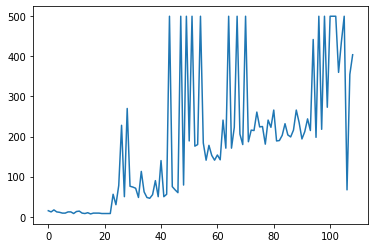

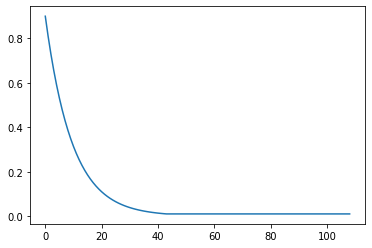

In [ ]:
plt.plot(scores)
plt.show()    
plt.plot(epsilon_decay)
plt.show()    